In [21]:
import fnmatch
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from ipywidgets import interactive
import numpy as np
import os
import glob
from scipy.ndimage import gaussian_filter as smooth
import platform

%run sessionlists
from VIGOR_utils import *
from VIGOR_plotting import *
from VIGOR_MODELS_Functions import *

plt.style.use('./Figures/paper.mplstyle')

In [22]:
a, _, _, _, _, _, mu_0, _, _, _, _, _ = pickle.load(open("picklejar/intact_lesionFITS.p", "rb"))

In [23]:
a

{'RatF00': {'60': 0.5901310582331137,
  '90': 0.6306353345903891,
  '120': 0.7364325378471169,
  '20': 0.9125197877459256,
  '10': 0.8479129158225402,
  '2': 0.9022353572296973,
  'rev10': 0.9229310745554681,
  'rev20': 0.9836063801483168},
 'RatF01': {'60': 1.0164464630878625,
  '90': 0.920140073252747,
  '120': 1.0980316793753082,
  '20': 1.276601421979892,
  '10': 1.1649779088679824,
  '2': 1.2957449309826659,
  'rev10': 1.3347131810472614,
  'rev20': 1.2747013123204893},
 'RatF02': {'60': 1.118107656413033,
  '90': 0.7681900852738957,
  '120': 0.928020313461604,
  '20': 1.653418186484776,
  '10': 1.4394094664665877,
  '2': 1.434940595590701,
  'rev10': 1.3918056384528161,
  'rev20': 1.7891496065325163},
 'RatM00': {'60': 1.7337022968247315,
  '90': 1.6970033026240547,
  '120': 1.620658985132039,
  '20': 2.2532900837219847,
  '10': 2.2439554262592747,
  '2': 2.083877236298039,
  'rev10': 2.156603403274781,
  'rev20': 2.223264786409457},
 'RatM01': {'60': 1.4325861732511038,
  '90': 

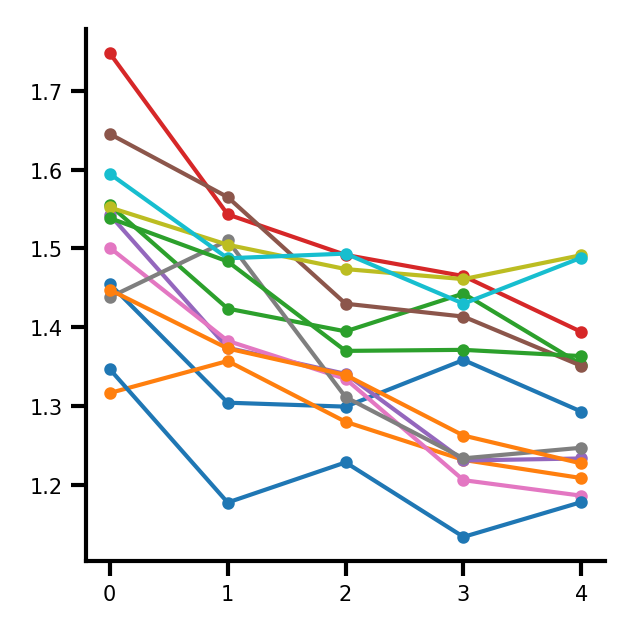

In [34]:
animalList = ['RatF00', 'RatF01', 'RatF02', 'RatM00', 'RatM01', 'RatM02', 
            'RatF32', 'RatF33', 'RatM31', 'RatM32', 'RatF42', 'RatM40', 'RatM43']

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
    
for animal in animalList:
    ax.plot([0, 1, 2, 3, 4], [mu_0[animal]["rev20"], mu_0[animal]["rev10"], mu_0[animal]["2"], mu_0[animal]["10"], mu_0[animal]["20"]], 
                label=animal, marker='o', markersize=2)




RatF00 -0.045836670636984066 0.0025710898946229525 [[-0.05895974]
 [-0.1176464 ]
 [-0.06893738]
 [ 0.03223559]
 [-0.01587542]]
RatF01 -0.10893435307798187 0.0020899241244209756 [[-0.19715466]
 [-0.06480362]
 [-0.08815893]
 [-0.09445926]
 [-0.10009529]]
RatF02 0.04586445617806541 0.0014683065589261675 [[0.04098647]
 [0.00161746]
 [0.026452  ]
 [0.11642648]
 [0.04383989]]
RatM00 0.14032457427589135 0.0024819522817002837 [[0.23357098]
 [0.12102428]
 [0.12336485]
 [0.13858032]
 [0.08508245]]
RatM01 -0.0434069487538824 0.0018362920793819424 [[ 0.02879038]
 [-0.04803077]
 [-0.02739754]
 [-0.09515513]
 [-0.07524168]]
RatM02 0.09300196520357736 0.0015139549663572174 [[0.13125318]
 [0.14292058]
 [0.06153519]
 [0.08720011]
 [0.04210077]]
RatF32 -0.06570604714753112 0.0021355768708493546 [[-0.01295452]
 [-0.03924817]
 [-0.03379364]
 [-0.12010286]
 [-0.12243105]]
RatF33 -0.039753605334370244 0.004232981068927206 [[-0.07580905]
 [ 0.08798089]
 [-0.05684755]
 [-0.09245944]
 [-0.06163288]]
RatM31 0.1

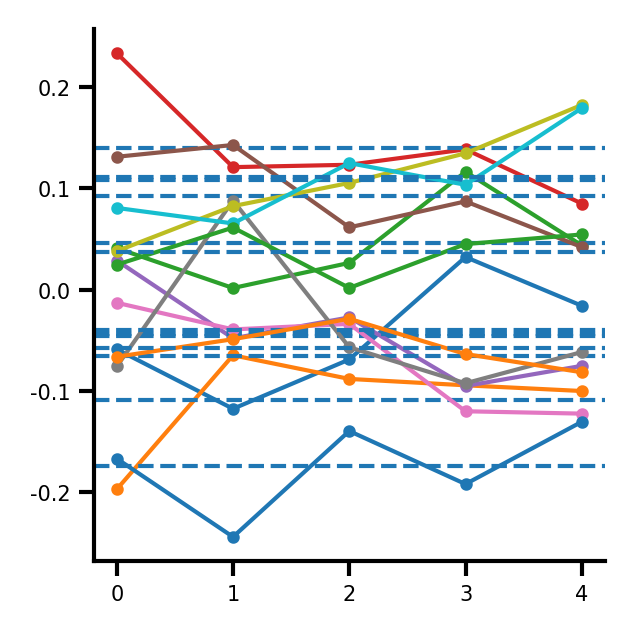

In [68]:
# adjust for conditino expected value E(y)
avg_rev20 = np.mean([mu_0[animal]["rev20"] for animal in animalList])
avg_rev10 = np.mean([mu_0[animal]["rev10"] for animal in animalList])
avg_2 = np.mean([mu_0[animal]["2"] for animal in animalList])
avg_10 = np.mean([mu_0[animal]["10"] for animal in animalList])
avg_20 = np.mean([mu_0[animal]["20"] for animal in animalList])

sigmaalpha = []
intercepts = {}
fig, ax = plt.subplots(1, 1, figsize=(2, 2))
for animal in animalList:
    x = np.array([0, 1, 2, 3, 4])
    y = np.array([mu_0[animal]["rev20"] - avg_rev20, 
        mu_0[animal]["rev10"] - avg_rev10,
        mu_0[animal]["2"] - avg_2, 
        mu_0[animal]["10"] - avg_10, 
        mu_0[animal]["20"] - avg_20, 
        ])
    ax.plot(x, y, label=animal, marker='o', markersize=2)


    X = np.ones((len(x), 1))  # Design matrix with constant term (intercept)
    y = y.reshape(-1, 1)  # Reshape y to a column vector
    coefficients = np.linalg.lstsq(X, y, rcond=None)[0]

    intercept = coefficients[0][0]

    ax.axhline(y=intercept, linestyle='--', label='Intercept')
    intercepts[animal] = intercept

    print(animal, np.mean(y), np.var(y), y)
    sigmaalpha.append(np.var(y))




RatF00 -8.326672684688674e-18 0.0025710898946229525 [-0.01312307 -0.07180973 -0.02310071  0.07807226  0.02996125]
RatF01 1.1102230246251566e-17 0.0020899241244209756 [-0.08822031  0.04413073  0.02077542  0.01447509  0.00883906]
RatF02 4.163336342344337e-18 0.0014683065589261679 [-0.00487799 -0.044247   -0.01941246  0.07056202 -0.00202457]
RatM00 3.8857805861880476e-17 0.002481952281700283 [ 0.09324641 -0.0193003  -0.01695973 -0.00174425 -0.05524213]
RatM01 -2.7755575615628915e-18 0.001836292079381943 [ 0.07219733 -0.00462382  0.0160094  -0.05174818 -0.03183473]
RatM02 2.4980018054066023e-17 0.0015139549663572174 [ 0.03825121  0.04991862 -0.03146678 -0.00580186 -0.0509012 ]
RatF32 -1.9428902930940238e-17 0.0021355768708493546 [ 0.05275153  0.02645788  0.0319124  -0.05439682 -0.056725  ]
RatF33 2.7755575615628915e-18 0.004232981068927206 [-0.03605544  0.12773449 -0.01709394 -0.05270583 -0.02187927]
RatM31 2.4980018054066023e-17 0.002361043490331884 [-0.07057861 -0.02611684 -0.00321049  0

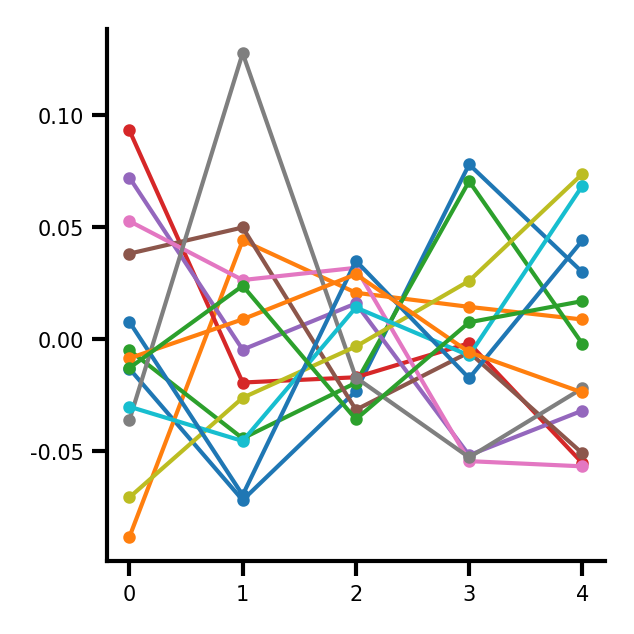

In [69]:
# adjust for individual intercept

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
sigmaepsilon = []
for animal in animalList:
    x = np.array([0, 1, 2, 3, 4])
    y = np.array([mu_0[animal]["rev20"] - avg_rev20 - intercepts[animal], 
        mu_0[animal]["rev10"] - avg_rev10 - intercepts[animal],
        mu_0[animal]["2"] - avg_2 - intercepts[animal], 
        mu_0[animal]["10"] - avg_10 - intercepts[animal], 
        mu_0[animal]["20"] - avg_20 - intercepts[animal], 
        ])
    ax.plot(x, y, label=animal, marker='o', markersize=2)

    print(animal, np.mean(y), np.var(y), y)
    sigmaepsilon.append(np.var(y))

In [54]:
Sa = np.mean(sigmaalpha)
Se = np.mean(sigmaepsilon)
print("Sa = ", Sa)
print("Se = ", Se)

Sa =  0.0019030901403110322
Se =  0.0019030901403110322


In [53]:
ICC = Sa / (Sa + Se)
ICC

0.5

In [63]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import MixedLM

# Generate example data
np.random.seed(2)
n_subjects = 10
n_measurements = 5

subject_ids = np.repeat(range(n_subjects), n_measurements)
expected_value = np.random.randn(n_subjects)
individual_intercepts = np.random.randn(n_subjects)
measurements = expected_value[subject_ids] + individual_intercepts[subject_ids] + np.random.randn(n_subjects * n_measurements) * 1.5

# Create a DataFrame with correct lengths
data = pd.DataFrame({'subject_id': subject_ids, 'measurement': measurements, 'expected_value': np.repeat(expected_value, n_measurements), 'individual_intercept': np.repeat(individual_intercepts, n_measurements)})

# Fit the linear mixed model
model = MixedLM.from_formula('measurement ~ expected_value + individual_intercept', data, groups=data['subject_id'])
result = model.fit()

# Calculate ICC
ICC = result.cov_re['Group'] / (result.cov_re['Group'] + result.scale)
print("Intraclass Correlation Coefficient (ICC):", ICC)

Intraclass Correlation Coefficient (ICC): Group    1.346399e-19
Name: Group, dtype: float64


/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


In [67]:
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
             Mixed Linear Model Regression Results
===============================================================
Model:              MixedLM   Dependent Variable:   measurement
No. Observations:   50        Method:               REML       
No. Groups:         10        Scale:                2.0930     
Min. group size:    5         Likelihood:           -89.8901   
Max. group size:    5         Converged:            Yes        
Mean group size:    5.0                                        
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept            -0.129    0.239 -0.541 0.589 -0.599  0.340
expected_value        0.983    0.198  4.953 0.000  0.594  1.372
individual_intercept  0.739    0.221  3.340 0.001  0.305  1.173
Group Var             0.000    0.368                           
===============================================================

"""

In [64]:
data

,subject_id,measurement,expected_value,individual_intercept
0,0,-1.182466,-0.416758,0.551454
1,0,-0.099955,-0.416758,0.551454
2,0,0.519552,-0.416758,0.551454
3,0,-1.348472,-0.416758,0.551454
4,0,-0.373537,-0.416758,0.551454
5,1,1.881665,-0.056267,2.292208
6,1,1.279459,-0.056267,2.292208
7,1,0.454523,-0.056267,2.292208
8,1,0.104115,-0.056267,2.292208
9,1,2.005698,-0.056267,2.292208
